## Test a Gyro GP relation in PyStan

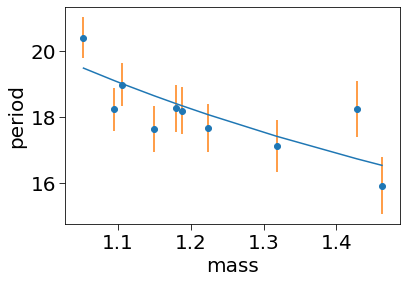

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pystan

npts = 10
mass = np.sort(np.random.randn(npts) * 0.2 + 1.2)

period = 2.0 * 10**1.0 * mass**-0.5
noise = mass * 0.6 * np.random.randn(npts)
sigma = mass * 0.6

fig, ax = plt.subplots()
ax.plot(mass, period)
ax.scatter(mass, period + noise,zorder=1)
ax.errorbar(mass, period+noise, yerr=sigma, fmt='|',zorder=0)
ax.set_xlabel('mass')
ax.set_ylabel('period')
plt.show()

In [18]:
from scipy import stats
slope, intercept, _, _, _ = stats.linregress(mass, period)
slope, intercept


(-7.124889052829245, 26.876313095498816)

In [19]:
gpfit = '''
data {
    int N;
    vector[N] P;
    real sigma[N];
    real M[N];
}
parameters {
    real<lower=0> alpha;
    real<lower=0> rho;
    real m0;
    real c0;
    vector[N] latP;
}
transformed parameters {
    matrix[N, N] cov = cov_exp_quad(M, alpha, rho)
                        + diag_matrix(rep_vector(1e-10, N));
    matrix[N, N] L_cov = cholesky_decompose(cov);
    vector[N] mu;
    for (n in 1:N){
        mu[n] = m0 * M[n] + c0;
    }
}
model {
    alpha ~ lognormal(0., .3);
    rho ~ lognormal(log(0.3), 0.1);
    m0 ~ normal(-10, 3);
    c0 ~ normal(25, 10);
    
    latP ~ multi_normal_cholesky(mu, L_cov)  ;
    P ~ normal(latP, sigma);
}
'''
sm = pystan.StanModel(model_code = gpfit, model_name='gpfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gpfit_f4e3972e6cff15aee916fb6f328345ba NOW.


In [20]:
data = {'N' : len(mass),
       'P' : period,
       'sigma' : np.abs(noise),
       'M' : mass}
init = {'alpha' : 0.4,
        'rho' : 1.,
        'm0' : slope,
        'c0' : intercept}

In [21]:
fit = sm.sampling(data=data, iter=20000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [22]:
print(fit)

Inference for Stan model: gpfit_f4e3972e6cff15aee916fb6f328345ba.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha          0.94    0.03   0.26   0.55   0.75   0.89   1.07   1.57     55   1.05
rho            0.31  3.6e-3   0.03   0.25   0.28    0.3   0.33   0.37     75   1.03
m0            -7.91    0.18   1.21 -10.21  -8.43   -7.9  -7.53   -4.6     45   1.06
c0            27.82    0.22   1.53  23.63  27.36  27.79  28.57  30.75     47   1.05
latP[1]       19.42    0.01   0.08  19.28  19.38  19.42  19.47   19.6     38   1.15
latP[2]        19.1  4.8e-3   0.03  19.04  19.08   19.1  19.12  19.17     39   1.11
latP[3]       19.01  4.1e-3   0.02  18.97   19.0  19.01  19.03  19.06     34   1.12
latP[4]       18.68  9.5e-3   0.04  18.59  18.66  18.69  18.71  18.77     20   1.33
latP[5]       18.47    0.01   0.06  18.32  18.43  18.47 

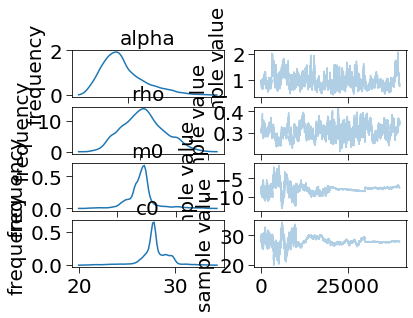

In [23]:
fit.plot(pars=['alpha','rho','m0','c0'])
plt.show()

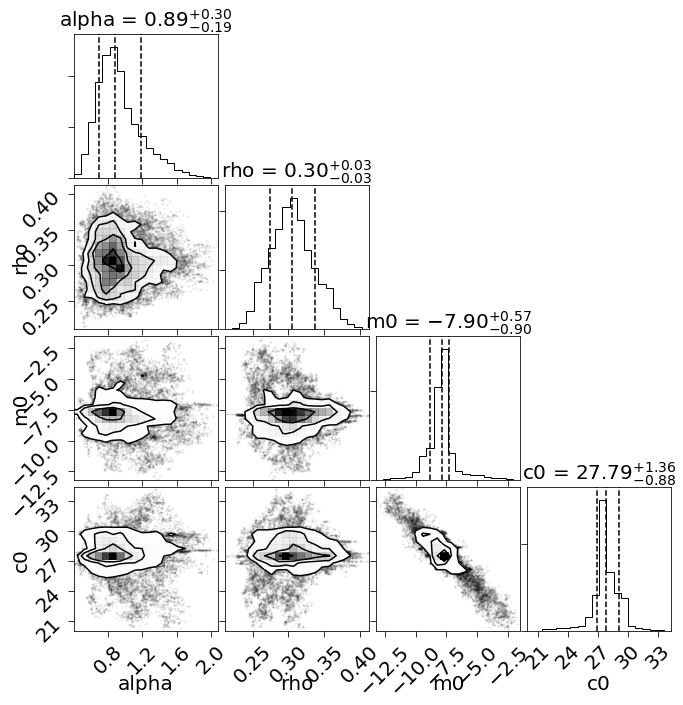

In [24]:
import corner
labels=['alpha','rho', 'm0','c0']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

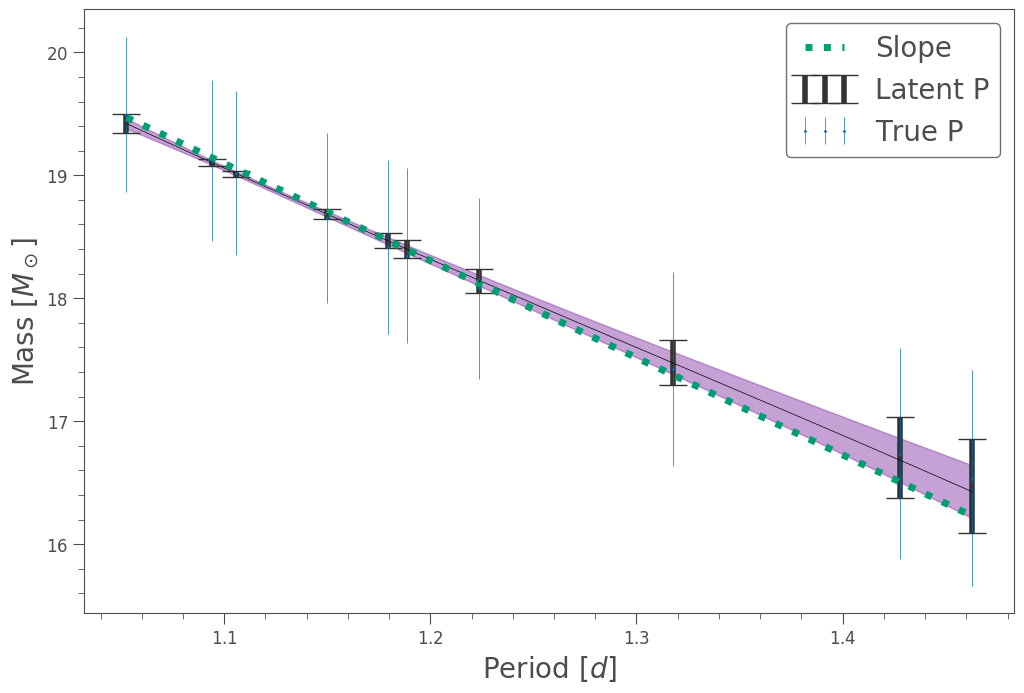

In [27]:
def kernel(x, y, p):
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)    

def predict(t_2, t_1, kernel, theta, a, c, y_1, y_v):
    B = kernel(t_1, t_2, theta).T
    A = kernel(t_1, t_1, theta).T + np.diag(y_v)
    C = kernel(t_2, t_2, theta).T
    
    y = c + np.dot(np.dot(B, np.linalg.inv(A)), (y_1 - a))
    Sigma = C - np.dot(np.dot(B, np.linalg.inv(A)),B.T)
            
    y_pred = y 
    sigma_new = np.sqrt(np.diagonal(Sigma))
    return y_pred, sigma_new

Ps = np.median(fit['latP'], axis=0)
Ps_std = np.std(fit['latP'],axis=0)
# Ps = period
# Ps_std = sigma

alpha = np.median(fit['alpha'])
rho = np.median(fit['rho'])

npts = 500

slope = np.median(fit['m0'])
intercept = np.median(fit['c0'])
mass2 = np.linspace(np.min(mass), np.max(mass), npts)

a = slope*mass + intercept
c = slope*mass2 + intercept


theta = [alpha, rho]
Ps_pred, sigmas = predict(mass2, mass, kernel, theta, a, c, Ps, Ps_std**2)

import mystyle

with plt.style.context(mystyle.ms):

    fig, ax = plt.subplots(figsize=(12,8))

    ax.fill_between(mass2, Ps_pred-sigmas, Ps_pred+sigmas, alpha=.5, color='#8d44ad')
    ax.plot(mass2, Ps_pred, c='k')
    ax.errorbar(mass, Ps, yerr=Ps_std, fmt='o', lw=4, capsize=10, label= 'Latent P')
    ax.errorbar(mass, period, yerr = sigma, fmt='o',  label='True P')

    plt.plot(mass2, c, lw=5, ls=':', label='Slope')
    
    ax.set_ylabel(r'Mass [$M_\odot$]', fontsize=20)
    ax.set_xlabel(r'Period [$d$]', fontsize=20)
    ax.legend(fontsize=20)
    plt.show()